<a href="https://colab.research.google.com/github/ayberkgurses/ViT/blob/main/vision_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
from torch.nn import functional as F

In [4]:
# ----- hyper parameteres -----
batch_size = 32
image_size = 224
patch_size = 16
embed_dim = 768
head_size = 32
learning_rate = 3e-4
dropout = 0
n_layers = 12
num_classes = 10
n_iters = 5000
eval_interval = 200
num_epochs = 100
mode = "eval"
# -----------------------------
context_length = (image_size // patch_size)**2 + 1
num_heads = embed_dim // head_size


In [5]:
mean = std = (0.5, 0.5, 0.5) # could be computed later

# resize and normalization recommended for ViT
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# datasets
trainset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)

testset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)

# data loaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# classes
classes = trainset.classes
print(classes)



100%|██████████| 170M/170M [00:05<00:00, 29.4MB/s]


['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


torch.Size([32, 3, 224, 224]) shape of one image batch
torch.Size([32]) shape of one label batch


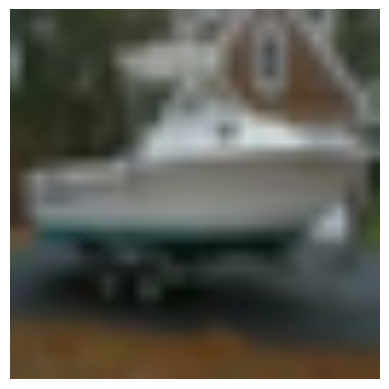

8


In [6]:
import numpy as np
import matplotlib.pyplot as plt

# get one batch
dataiter = iter(trainloader)
images, labels = next(dataiter)

# print shapes
print(images.shape, "shape of one image batch")
print(labels.shape, "shape of one label batch")

img = images[0]
label = labels[0]

# show image
def imshow(img):
  img = img.numpy().transpose((1, 2, 0))
  img = img * std + mean
  img = np.clip(img, 0, 1)
  plt.imshow(img)
  plt.axis("off")
  plt.show()

imshow(img)
print(label.item())

In [7]:
class PatchEmbed(nn.Module):
  def __init__(self, image_size=image_size, patch_size=patch_size, in_channels=3, embed_dim=embed_dim):
    super().__init__()
    self.image_size = image_size
    self.patch_size = patch_size
    self.in_channels = in_channels
    self.embed_dim = embed_dim

    self.num_patches = (image_size // patch_size)**2

    # trainable linear projection of flattened patches
    patch_dim = in_channels * (patch_size**2)
    self.proj = nn.Linear(patch_dim, embed_dim)

    # prepending the CLS token
    self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))

    # adding the positional embedding
    self.pos_embed = nn.Parameter(torch.zeros(1, self.num_patches+1, embed_dim))

  def forward(self, x):
    B, C, H, W = x.shape

    # x.shape = (B, C, H/ps, W/ps, ps, ps)
    x = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)


    x = x.reshape(B, C, self.num_patches, self.patch_size, self.patch_size)
    x = x.permute(0, 2, 1, 3, 4).reshape(B, self.num_patches, C*(patch_size**2))

    x = self.proj(x) # (B, N, embed_dim)

    cls_tokens = self.cls_token.expand(B, 1, self.embed_dim)
    x = torch.cat((cls_tokens, x), dim=1)

    x = x + self.pos_embed

    return x

In [8]:
img = torch.randn(batch_size, 3, image_size, image_size)
embedder = PatchEmbed()
v0 = embedder(img)
v0.shape

torch.Size([32, 197, 768])

In [9]:
toy = torch.arange(1, 61)
toy1 = toy.reshape((2, 6, 5))
toy2 = toy1.unfold(1, 3, 3)
toy1, toy2

(tensor([[[ 1,  2,  3,  4,  5],
          [ 6,  7,  8,  9, 10],
          [11, 12, 13, 14, 15],
          [16, 17, 18, 19, 20],
          [21, 22, 23, 24, 25],
          [26, 27, 28, 29, 30]],
 
         [[31, 32, 33, 34, 35],
          [36, 37, 38, 39, 40],
          [41, 42, 43, 44, 45],
          [46, 47, 48, 49, 50],
          [51, 52, 53, 54, 55],
          [56, 57, 58, 59, 60]]]),
 tensor([[[[ 1,  6, 11],
           [ 2,  7, 12],
           [ 3,  8, 13],
           [ 4,  9, 14],
           [ 5, 10, 15]],
 
          [[16, 21, 26],
           [17, 22, 27],
           [18, 23, 28],
           [19, 24, 29],
           [20, 25, 30]]],
 
 
         [[[31, 36, 41],
           [32, 37, 42],
           [33, 38, 43],
           [34, 39, 44],
           [35, 40, 45]],
 
          [[46, 51, 56],
           [47, 52, 57],
           [48, 53, 58],
           [49, 54, 59],
           [50, 55, 60]]]]))

In [10]:
class MultiHeadAttention(nn.Module):
  def __init__(self, embed_dim=embed_dim, head_size=head_size, dropout=dropout):
    super().__init__()
    self.embed_dim = embed_dim
    self.head_size = head_size
    self.num_heads = num_heads
    self.dropout = dropout

    self.qkv = nn.Linear(embed_dim, 3 * embed_dim)

    self.proj = nn.Linear(embed_dim, embed_dim)

    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    B, _, _ = x.shape

    qkv = self.qkv(x) # (B, context_length, 3 * embed_dim)

    qkv = qkv.reshape(B, context_length, 3, num_heads, head_size)

    q, k, v = qkv.unbind(dim=2) # (B, context_length, num_heads, head_size)

    m = nn.Softmax(dim=3)

    q = q.transpose(1, 2)
    k = k.transpose(1, 2)
    attention_matrix = m(q.matmul(k.transpose(2, 3)) / head_size**0.5) # (B, num_heads, context_length, context_length)

    v = v.transpose(1, 2)

    context_matrix = attention_matrix @ v # (B, num_heads, context_length, head_size)
    context_matrix = context_matrix.transpose(1, 2)
    context_matrix = torch.cat(context_matrix.unbind(dim=2), dim=2) # (B, context_length, embed_dim)

    out = self.dropout(self.proj(context_matrix))

    return out # (B, context_length, embed_dim)


In [11]:
import torch
x = torch.randn(2, 3)
x
y = torch.cat(x.unbind(dim=1), dim=0)
x, y

(tensor([[ 0.1753,  0.9972, -0.6128],
         [-1.0927, -0.4112, -0.2515]]),
 tensor([ 0.1753, -1.0927,  0.9972, -0.4112, -0.6128, -0.2515]))

In [12]:
import torch
x = torch.tensor([1.0, 2.0, 3.0])
print(torch.softmax(x, dim=0))        # [0.09, 0.24, 0.66]
print(torch.softmax(x*10, dim=0))     # [0.0, 0.0, 1.0]

tensor([0.0900, 0.2447, 0.6652])
tensor([2.0611e-09, 4.5398e-05, 9.9995e-01])


In [13]:
class MLP(nn.Module):
  def __init__(self, embed_dim=embed_dim, out_dim=embed_dim):
    super().__init__()
    self.embed_dim = embed_dim
    self.out_dim = out_dim
    self.net = nn.Sequential(nn.Linear(embed_dim, embed_dim * 4),
                             nn.GELU(),
                             nn.Linear(embed_dim * 4, out_dim),
                             nn.Dropout(dropout))

  def forward(self, x):
    return self.net(x)


In [14]:
class Block(nn.Module):
  def __init__(self, embed_dim=embed_dim, head_size=head_size):
    super().__init__()
    self.embed_dim = embed_dim
    self.head_size = head_size

    self.layer_norm = nn.LayerNorm(embed_dim)

    self.multi_head_attention = MultiHeadAttention()

    self.MLP = MLP()


  def forward(self, x):
    x1 = self.layer_norm(x)

    x2 = self.multi_head_attention(x1) + x

    x3 = self.layer_norm(x2)

    out = self.MLP(x3) + x2

    return out


In [15]:
class ViT(nn.Module):
  def __init__(self, n_layers=n_layers):
    super().__init__()
    self.n_layers = n_layers

    self.patch_embed = PatchEmbed()

    self.blocks = nn.Sequential(*[Block() for _ in range(self.n_layers)])

    self.layer_norm = nn.LayerNorm(embed_dim)

    self.classification_head = MLP(out_dim=num_classes)

  def forward(self, images, targets):
    img_embd = self.patch_embed(images) # (B, context_length, embed_dim)

    cls_token = self.layer_norm(self.blocks(img_embd))[:, 0, :] # (B, embed_dim)

    logits = self.classification_head(cls_token) # (B, num_classes)

    loss = F.cross_entropy(logits, targets)

    return logits, loss




In [16]:
if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"

model = ViT()
m = model.to(device)

print(sum(p.numel() for p in m.parameters()) * 1e-6, "million parameters")

optimizer = torch.optim.AdamW(m.parameters(), lr=learning_rate)

loss_log = []

88.173322 million parameters


In [ ]:
if mode=="train"
  for epoch in range(num_epochs):
    for num_epoch, (images, targets) in enumerate(trainloader):

      images, targets = images.to(device), targets.to(device)

      _, loss = m.forward(images, targets)

      if num_epoch == num_epochs-1 or num_epoch % eval_interval == 0:
        loss_log.append(loss)
        print(loss)

      optimizer.zero_grad(set_to_none=True)
      loss.backward()
      optimizer.step()

tensor(2.3116, grad_fn=<NllLossBackward0>)


In [ ]:
  total = 0
  correct = 0
  total_loss = 0.0
  m.eval()

  with torch.no_grad():
    for images, targets in testloader:

      images, targets = images.to(device), targets.to(device)

      logits, loss = m(images, targets)

      total_loss = loss.item() * batch_size

      preds = logits.argmax(dim=1)

      correct += (preds==targets).sum().item()

      total += batch_size

  accuracy = 100 * correct / total
  accuracy